Note on using tensorflow with jupyter. I ran into issues that my python had the modules, but not my ipython. To fix this, I linked the tensorflow to a python kernel:

``  python -m ipykernel install --user --name tensorflow --display-name "Python 3.8 (TF)"``

Then I re-started the jupyter lab with the kernel ``Python 3.8 (TF)``.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from keras import layers


import torch
import torch.nn as nn


# 1. Convolutional Neural Networks


Just like MLPs, each neuron in a CNN receives some inputs, performs a dot product and optionally follows it with a non-linearity. CNNs are designed to have images as inputs. When using fully connected layers, images have too many samples and a fully connected layer would have too many trainable parameters. CNN layers are not 1D hidden layers, they are volume of neurons.



<img src="figures/cnn2.jpeg" alt="cnn" style="width: 400px;"/>
<center>Figure: A ConvNet arranges its neurons in three dimensions (width, height, depth), as visualized in one of the layers.</center>


The classic sequencing of a CNN (or a block) is: Convolutional Layer, Activation Layer, Pooling Layer, Fully Connected Layer.

<!-- <img src="figures/Convolution.png" alt="cnn" style="width: 400px;"/> -->
## 1.1 Anatonmy of the Conv layer
* The **input** "feature map" is the input data for a given layer. It is 3D for a 2D convolution. The three dimensions are: *height*, *width*, *depth/channels*. For instance, width and heights are the 2D images (e.g. 32x32 pixels), the depth can be the different RGB (1 image per color R, G, B). The ordering of the dimension of the input is captured in the ``data_format`` argument with ``'channel_first'`` . When including 3D data (RGB of images, or multi channels of geophysical measurement's spectrograms), write out the input shape: batch_shape + (channels, rows, cols) if ``data_format='channels_first'`` or batch_shape + (rows, cols, channels) if ``data_format='channels_last'``. The input size should be divisible by 2 many times (32, 64, 96, 224, 512).
 
* The **filters** are the **convolution kernels** are the dimensionality of the output space. In general, the number of filters is greater than the input number of channels: the network heights and widths usually decreases throughout the networks, thus increasing the depth or number of filters does not increase the complexity too much. 
* The **kernel size** is a list of 2 integer that specifies the height and width of the 2D convolution kernel. If both integers are equal, just use a single integer value. The kernel is a filter that has weights to apply on the input values, each kernel map as 1 bias. Let's take an example of a 3x3 input feature map, a 2x2 kernel size, a 2x2 output feature map. The highlighted part of the map in blue are those we focus on:

<center> <img src="figures/convolution.png" width="600"></center>
<center>Convolution with kernel window (Fig. 6.2.1 from Dive into Deep Learning).</center>

In the example above, we perform the following operation: the top-left output value is = 0×0+1×1+3×2+4×3=19. Then we repeat the process until all elements of the output map are field. We also repeat this for each filter. Usually prefer using small but many kernels/filters.


* The **stride** is the step that the convolution skips when being applying the filters/kernels. Small strides work better in practice. It is one way to reduce the feature map, but the most popular choice for this is to use ***maxpooling***.


* The **padding** is set to either ``SAME`` or ``VALID`` depending on whether the edges of the feature map are extended and filled with zeros (same) to fit the total length of the kernel size and stride, or wether they are ignored (valid). Prefer to use ``SAME`` especially for the hidden conv layers to avoid loosing data and feature knowledge.


The convolution can be 1D or 2D depending on the array input:

When the input a single dimension array (vector, time series), use a Conv1D layer.
https://keras.io/api/layers/convolution_layers/convolution1d/


When the input is a 2D image (2D array) or a time series with multiple channels (example of a seismogram with 3 components), use Conv2D layers.
https://keras.io/api/layers/convolution_layers/convolution2d/

Here are examples of a 32x32 image with three channels (RGB) sent to a 64 output channels/filters with a size of kernels of 6 pixels. The padding is "SAME" such that the edges of the feature maps are filled with zeros. We write the function for Keras and Pytorch.

In [2]:
# Keras&TF version
keras.layers.Conv2D(filters=64, kernel_size=6, padding='same', activation='relu', input_shape=(32,32,3))

# pytorch version
torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=6)

Conv2d(3, 64, kernel_size=(6, 6), stride=(1, 1))

## 1.2 Pooling layers

**MaxPooling** layers are downsampling layers. It ouputs the max value of each channel of windwos in a feature map. Downsampling reduces the size of the feature-map, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows (in terms of the fraction of the original input they cover). The pooling size is the factor of reduction in the layer size.


<center><img src="figures/max_pooling.png" width="600"></center>
<center>Maximum pooling (Fig. 6.5.1 from Dive into Deep Learning).</center>

<!-- 114 / 2 = 57 and 80 / 2 = 40 -->

**General pooling** are other functions, such as average pooling or even L2-norm pooling. Average pooling was often used historically but has recently fallen out of favor compared to the max pooling operation, which has been shown to work better in practice.


Pooling is designed to reduce the complexity and model size in order to deal with overfitting and computational expense. Some argue that striding is sufficient. Some also founds that auto-encoders and generative adversarial networks perform better without pooling.


## 1.3 Other notes

In the convolutional layer, the neurons are not connected to every part of the input data.
The anatomy of a Convolutional layer.

A dense layer learns global patterns. A convolution layer learns local patterns. Because of that, CNNs are **translation invariant** as they pick part of the image of time series and generalize the learning elsewhere. CNNs learn **hierarchical patterns**: a first layer learns a local pattern, a second layer combines the local features to create a broader scale feature.



# 2 Practice on LeNet-5 networks

We will create a CNN LeNet architecture (LeCun et al, 1998) to classify images from the fashion MNIST data. We will write it in Keras/Tensorflow and in PyTorch.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
class_names = ["tshirt","trousers","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
X_val,X_train = X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_val,y_train = y_train_full[:5000],y_train_full[5000:]
# Here we have to add one dimension to the images in order to match the conv2D requirements in Keras.
# And we do it for all variables.
X_train=X_train[...,None]
X_val=X_val[...,None]
X_test=X_test[...,None]
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train))
print(len(np.unique(y_train)))

(55000, 28, 28, 1)
(55000,)
[0 1 2 3 4 5 6 7 8 9]
10


### 2.1 Create the model

We will create a CNN LeNet-5 architecture (LeCun et al, 1998) that is a sequential stack of 3 convolutional layers, 2 fully connected layers. There are several graphical representations of networks that we often find in the literature, with a few examples below.
<center><img src="figures/lenet.svg" width="600"></center>
<center>LeNet-5 architecture</center>
<center><img src="figures/lenet-vert.svg" width="200"></center>
<center>LeNet-5 architecture</center>

Using words, we can see that the CNN is composed of an input map of size 28x28 pixels, and the images are in gray scales so there is a single channel. It is followed by a convolution layer of size 28x28 and depth 6 (# of channels) and kernel sizes of 5x5, a pooling layer of size 2 - stride 2, a conv layer of depth 6 (or 6 channels) and kernel size 5x5, another pooling layer of size 2 - stride 2, and then 3 fully connected (dense) layers of respective sizes 120, 84, 10. The activation functions in the original LeNet-5 were sigmoids and the last activation function was a Gaussian function,  which we replaced with softmax. One can test the role of activation functions by changing them to ReLu.

In [4]:
model = keras.Sequential([
# Must define the input shape in the first layer of the neural network
keras.layers.Conv2D(filters=6, kernel_size=5, padding='same', activation='sigmoid', input_shape=(28,28,1)),
keras.layers.AveragePooling2D(2), # you could replace with MaxPooling2D
keras.layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='sigmoid'),
keras.layers.AveragePooling2D(2),# you could replace with MaxPooling2D
keras.layers.Flatten(),
keras.layers.Dense(120, activation='sigmoid'),
# keras.layers.Dropout(0.5),
keras.layers.Dense(84, activation='sigmoid'),
# keras.layers.Dropout(0.5),
keras.layers.Dense(10, activation='softmax')])
# Take a look at the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

Model in pytorch

In [5]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

In [6]:
model_torch = torch.nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size=5,
                                               padding=2), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                          nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

In [7]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
print('Initial input shape: \t', X.shape)
for layer in model_torch:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Initial input shape: 	 torch.Size([1, 1, 28, 28])
Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


### 2.2 Compile the model
choose the appropriate loss function. We have a multi-class classification example, so we will use the categorical crossentropy. We will use the Adam optimizer to be fast. We will use the accuracy for the metric on the loss.

In [8]:
cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", # use the validation loss as a metric
    patience=2, # number of epochs to wait until there is improvement
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)
model.compile(loss="sparse_categorical_crossentropy",
             optimizer='adam',
             metrics="accuracy")

### 2.3 Train the model
Choose the batch size, the number of epochs (iterations). Fit and be patient: grab a coffee, watch a webinar.

In [9]:
history = model.fit(X_train,y_train,batch_size=24,epochs=20,validation_data=(X_val,y_val),callbacks=cb)

Epoch 1/20
2292/2292 [==============================] - 15s 6ms/step - loss: 0.8668 - accuracy: 0.6758 - val_loss: 0.5406 - val_accuracy: 0.8046
Epoch 2/20
2292/2292 [==============================] - 16s 7ms/step - loss: 0.5054 - accuracy: 0.8112 - val_loss: 0.4286 - val_accuracy: 0.8404
Epoch 3/20
2292/2292 [==============================] - 18s 8ms/step - loss: 0.4274 - accuracy: 0.8407 - val_loss: 0.3861 - val_accuracy: 0.8540
Epoch 4/20
2292/2292 [==============================] - 21s 9ms/step - loss: 0.3814 - accuracy: 0.8583 - val_loss: 0.3478 - val_accuracy: 0.8760
Epoch 5/20
2292/2292 [==============================] - 23s 10ms/step - loss: 0.3533 - accuracy: 0.8691 - val_loss: 0.3277 - val_accuracy: 0.8778
Epoch 6/20
2292/2292 [==============================] - 25s 11ms/step - loss: 0.3332 - accuracy: 0.8767 - val_loss: 0.3204 - val_accuracy: 0.8830
Epoch 7/20
2292/2292 [==============================] - 23s 10ms/step - loss: 0.3172 - accuracy: 0.8824 - val_loss: 0.3144 - val

### 2.4 Evaluate the model
Plot the acuracy scores as a function of epochs to see how well we train. Note that we used the ``callbacks`` option to stop after a few iterations if there was no more improvememnts

313/313 [==============================] - 4s 14ms/step - loss: 0.3807 - accuracy: 0.8615

 Test accuracy: 0.8615000247955322


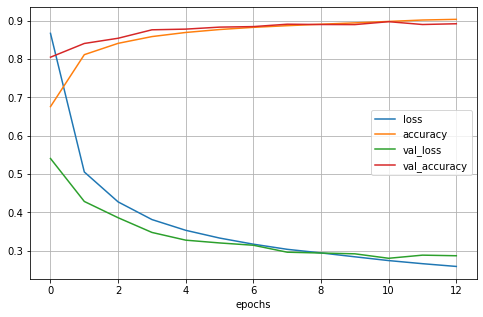

In [10]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epochs')

# Evaluate the model on test set
score = model.evaluate(X_test, y_test, verbose=1)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])

Here is the PyTorch version.
First we need to convert from numpy arrays to pytorch tensors

In [35]:
# prep data for training and testing
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
pXtrain = torch.from_numpy(X_train).float()
pXtest = torch.from_numpy(X_test).float()
pytrain = torch.from_numpy(y_train).type(torch.LongTensor)
pytest = torch.from_numpy(y_test).type(torch.LongTensor)



# transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])
# dataset = MyDataset(data, targets, transform=transform)
# dataloader = DataLoader(dataset, batch_size=5)

train_data = TensorDataset(pXtrain,pytrain)
test_data= TensorDataset(pXtest,pytest)



train_dataloader = DataLoader(train_data,batch_size=24)
test_dataloader = DataLoader(test_data,batch_size=24)

In [36]:
# function defined to train the model
def train(model, n_epochs, lr, trainloader, testloader=None):

    # Save loss and accuracy for plotting
    loss_time = np.zeros(n_epochs)
    accuracy_time = np.zeros(n_epochs)

    # Initialize weights
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)

    # Define loss and optimization method
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    # Loop on number of epochs
    for epoch in range(n_epochs):
        # Initialize the loss
        running_loss = 0
        model.train()
        # Loop on samples in train set
        for i, (X, y) in enumerate(trainloader):
            optimizer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            # Add the value of the loss for this sample
            running_loss += l.item()
        # Save loss at the end of each epoch
        loss_time[epoch] = running_loss / len(trainloader)

        # After each epoch, evaluate the performance on the test set
        if testloader is not None:
            correct = 0
            total = 0
            # We evaluate the model, so we do not need the gradient
            with torch.no_grad():
                # Loop on samples in test set
                for i, (X, y) in enumerate(testloader):
                    y_hat = model(X)
                    # Compare predicted label and true label
                    _, predicted = torch.max(y_hat.data, 1)
                    total += y.size(0)
                    correct += (predicted == y).sum().item()
            # Save accuracy at the end of each epochs
            accuracy_time[epoch] = 100 * correct / total
    
        # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
              (epoch + 1, running_loss / len(trainloader), 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss / len(trainloader)))

    # Save history of loss and test accuracy
    if testloader is not None:
        return (loss_time, accuracy_time)
    else:
        return (loss_time)

In [37]:
(loss, accuracy) = train(model_torch, 10, 0.9, train_dataloader, test_dataloader)

[Epoch 1] loss: 2.314 - accuracy: 10.000
[Epoch 2] loss: 1.036 - accuracy: 73.080
[Epoch 3] loss: 0.484 - accuracy: 71.310
[Epoch 4] loss: 0.402 - accuracy: 72.180
[Epoch 5] loss: 0.362 - accuracy: 72.840
[Epoch 6] loss: 0.336 - accuracy: 74.160
[Epoch 7] loss: 0.317 - accuracy: 76.230
[Epoch 8] loss: 0.301 - accuracy: 76.210
[Epoch 9] loss: 0.287 - accuracy: 76.670
[Epoch 10] loss: 0.276 - accuracy: 77.570


In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, 11), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, 11), accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# 3. Example on seismic data

In this class, we will use a simplified version of ConvNetQuake (Perol et al, 2018). The network was designed as a classification that predicted the nature and location of the seismic events. The earthquakes from a known earthquake catalog were clustered using k-means, and each earthquake waveforms were  We will use the two seismic station seismograms already labeled as "earthquakes" or "noise" to perform.


<img src="figures/ConvNetQuake.jpg" alt="ConvNetQuake" style="width: 400px;"/>


### 3.1 read the data
data is stored in Gdrive here https://drive.google.com/drive/folders/1LF2_bBHvUyinJuaiMwhG4C_rMErerG80?usp=sharing. Download the data and place it in a "data" folder.

In [ ]:
# load OK029 template data:
with h5py.File("./data/templates_029.h5", "r") as f:
    eq1 = np.asarray(f['earthquakes']);neq1=eq1.shape[0]
    no1 = np.asarray(f["noise"])


# # load OK027 template data:
# with h5py.File("./data/templates_027.h5", "r") as f:
#     eq2 = np.asarray(f['earthquakes'])
#     no2 = np.asarray(f["noise"])

### 3.2 Prep the data

In [ ]:
#  allocate memory
quakes=np.zeros(shape=(eq1.shape[0],1000,3),dtype=np.float32)
noise=np.zeros(shape=(no1.shape[0],1000,3),dtype=np.float32)
# quakes2=np.zeros(shape=(eq2.shape[0],1000,3),dtype=np.float32)
# noise2=np.zeros(shape=(no2.shape[0],1000,3),dtype=np.float32)

# Normalize the seismograms to their peak amplitudes
for iq in range(eq1.shape[0]):
    for ic in range(3):
        if np.max(np.abs(eq1[iq,ic,:]))>0:
            quakes[iq,:,ic]=eq1[iq,ic,:]/np.max(np.abs(eq1[iq,ic,:]))
            
for iq in range(no1.shape[0]):
    for ic in range(3):
        if np.max(np.abs(no1[iq,ic,:]))>0:
            noise[iq,:,ic]=no1[iq,ic,:]/np.max(np.abs(no1[iq,ic,:]))

# for iq in range(eq2.shape[0]):
#     for ic in range(3):
#         if np.max(np.abs(eq2[iq,ic,:]))>0:
#             quakes2[iq,:,ic]=eq2[iq,ic,:]/np.max(np.abs(eq2[iq,ic,:]))
            
# for iq in range(no12.shape[0]):
#     for ic in range(3):
#         if np.max(np.abs(no2[iq,ic,:]))>0:
#             noise2[iq,:,ic]=no2[iq,ic,:]/np.max(np.abs(no2[iq,ic,:]))

# select data that is strictly positive and finite
iq1=np.where( ( np.abs(quakes[:,0,0])>0)&(np.isfinite(quakes[:,0,0])))[0]
# iq2=np.where( (np.abs(quakes2[:,0,0])>0)&(np.isfinite(quakes2[:,0,0])))[0]

In [ ]:
# label & data
y = np.concatenate((np.ones(len(iq1)+len(iq2),dtype=np.int),np.zeros(len(iq1)+len(iq2),dtype=np.int))) # 0 for noise, 1 for event
# X = np.zeros(shape=(len(train_labels),1000,3,1))
X= np.concatenate((quakes[iq1,:,:],quakes2[iq2,:,:],noise[iq1,:,:],noise2[iq2,:,:]),axis=0)
X=X[...,None]# add that depth/channel dimension

nlabels=2 # = len(np.unique(y))

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

### 3.3 Define ML model
ConvNetQuake is a simple stack of 8 conv2d layers with 32 channels, stride of 2 kernel size of 3x3, ReLu activation functions, padding is the same

In [ ]:
# building the architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1000,3,1), use_bias=True, strides=2, padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, padding='SAME'))
model.add(layers.Flatten())
model.add(layers.Dense(nlabels, activation='softmax'))

In [ ]:
# compile the network
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# training
history=model.fit(X_train,y_train,validation_split=0.2, epochs=20, batch_size=128,shuffle=True) 


In [ ]:
# check for overfitting
history_dic = history.history
loss_values = history_dic['loss']
val_loss_values = history_dic['val_loss']
acc_values = history_dic['acc']
val_acc_values = history_dic['val_acc']
epochs=range(1,len(loss_values)+1)
fig,ax=plt.subplots(2)
ax[0].plot(epochs,loss_values,'bo',label='Training loss')
ax[0].plot(epochs,val_loss_values,'b',label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs,acc_values,'bo',label='Training accuracy')
ax[1].plot(epochs,val_acc_values,'b',label='Validation accuracy')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()


In [ ]:
# testing
test=model.evaluate(X_test,y_test,batch_size=64,verbose=1)
print('loss and accuracy at test')
print(test)

## Tuning CNN networks

There are many hyperparameters and model choices to make:
* learning rate, optimizer, batch_size, activation functions, loss functions
* architecture: number of layers, depth of kernels, activation functions, regularization, batch normalization

One can treat the hyperparameter search as an optimization problem. Keras tuner (https://keras-team.github.io/keras-tuner/) can be used to randomize the grid search.

http://caffe.berkeleyvision.org/model_zoo.html

# 4. How to read and recode published networks

Let us say that you read a research paper explaining the architecture of the convolutional neural network used by the authors to carry out their data analysis. How will you try to reproduce their results? They do not provide a github!

Let us look at the following paper:

Rouet-Leduc, B., Hulbert, C., McBrearty, I. W., Johnson, P. A. (2020). Probing slow earthquakes with deep learning. Geophysical Research Letters, 47, e2019GL085870. https://doi.org/10.1029/2019GL085870.

<img src="figures/cnn_rouet-leduc.png" width="600">
<center>Schematic of the CNN and its architecture (Figure 1 from Rouet-Leduc et al. (2020).</center>

* **Batch Normalization** => unclear from the paper, but this seems to be the normalization of the data
* **Dropout** => unclear from the paper what this is
* **Input** Spectrogram = Image with 129 x 95 x1 pixels
* **Conv2D** convolution is has a kernel size of 16x16 feature map of size 114x80 is depth 32 (# of channels), activation is ReLU (found in the supplementary material)
* **Maxpooling** of size 2
* **Dropout** 5%, found in the supplementary material
* **Conv2D** of kernel size 8 x 8, depth 64
* **Maxpooling** of size 2
* **Dropout** 5%, found in the supplementary material
* **Full Connected - Dense layers** with 36608 neurons (found in the supplementary material)
* **Full Connected - Dense layers** with 10 neurons (found in the supplementary material)
* **Full Connected - Dense layers** with 1 neuron, sigmoid activation function (found in the supplementary material)

In [ ]:
model = torch.nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=16),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Dropout(0.05),
                            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=8),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2),
                            nn.Dropout(0.05),
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4),
                            nn.Flatten(),
                            nn.Linear(36608, 10),
                            nn.Sigmoid(),
                            nn.Linear(10, 1),
                            nn.Sigmoid())